In [ ]:
!pip install aif360
!pip install fairlearn

In [3]:
%matplotlib inline
import pandas as pd
import numpy as np
import random

# for efficiency comparison
from time import time

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
plt.style.use('seaborn-white')
import seaborn as sns


#from aif360.datasets import BinaryLabelDataset
#from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
#from aif360.algorithms.inprocessing import PrejudiceRemover

from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_curve, auc
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn import calibration

from scipy.spatial import distance
import scipy.optimize as optim

from IPython.display import Markdown, display
import warnings
warnings.filterwarnings("ignore")

# Data Preprocessing


In [4]:
# load csv
raw_data = pd.read_csv('../data/compas-scores-two-years.csv')
raw_data.shape[0]

7214

### (1) Data Cleaning

However not all of the rows are usable for analysis.

There are a number of reasons to remove rows because of missing data: * If the charge date of a defendants Compas scored crime was not within 30 days from when the person was arrested, we assume that because of data quality reasons, that we do not have the right offense;

- In a similar vein, ordinary traffic offenses (i.e., those with a c_charge_degree of O) will not result in Jail are removed;


In [5]:
df = raw_data[['age', 'c_charge_degree', 'race', 'age_cat',
                    'score_text', 'sex', 'priors_count', 'days_b_screening_arrest',
                    'decile_score', 'is_recid', 'c_jail_in',
                    'c_jail_out', 'two_year_recid']]\
                    .query('days_b_screening_arrest <= 30')\
                    .query('days_b_screening_arrest >= -30')\
                    .query('is_recid != -1')\
                    .query('c_charge_degree != "O"')\
                    .query('score_text != "N/A"')
df.shape[0]

6172

In [6]:
from datetime import datetime

dt1 = list(map(lambda x: datetime.strptime(x,'%Y-%m-%d %H:%M:%S').date(), df['c_jail_out']))
dt2 = list(map(lambda x: datetime.strptime(x,'%Y-%m-%d %H:%M:%S').date(), df['c_jail_in']))

len_stay = [(a-b).days for a,b in zip(dt1,dt2)]


In [7]:
df['length_of_stay'] = len_stay
df = df.drop(['c_jail_out', 'c_jail_in'], axis=1)

In [8]:
#rearrange columns so y is the last column
cols = df.columns.tolist()
cols = cols[:-2] + cols[-1:] + cols[-2:-1]
df = df[cols]

Export new csv file into `../outputs`

In [9]:
df.to_csv("../output/csty_filtered.csv", index=False)

### (2) Data Subsetting for 'African-American' and 'Caucasian'
Now we have the new csv file to work with, load the new csv data file ...

In [10]:
# load new csv
data = pd.read_csv('../output/csty_filtered.csv')

Check what kinds of race we have in the dataset -- we only want African American and Caucasian

In [11]:
print("We have {} races in our dataset: {}".format(data.race.unique().size, data.race.unique()))

We have 6 races in our dataset: ['Other' 'African-American' 'Caucasian' 'Hispanic' 'Asian'
 'Native American']


Subset data with only race of interest

In [12]:
# subset data
races = ['African-American', 'Caucasian']
dat_tidy = data[data.race.isin(races)]

Check unique values of `Race` column, we can see now we only have 2 races for the purpose of this study

In [13]:
print("We have {} races in our dataset: {}" .format(dat_tidy.race.unique().size, dat_tidy.race.unique()))

We have 2 races in our dataset: ['African-American' 'Caucasian']


### (3) Data Splitting

 a. Split data into Sensitive data, Nonsensitive data

Binary sensitive attribute:
we want to only subset data with 2 races in interest: Caucasian(1) and African American(0)

Binary Class (y):
`two-year-recid` column

In [14]:
Y_column = ['two_year_recid']
cat_columns = []
num_columns = []

for col in dat_tidy.columns.values:
    if col in Y_column:
        continue
    elif dat_tidy[col].dtypes in ('int64', 'float64') :
        num_columns += [col]
    else:
        cat_columns += [col]

The following three chunks aim to transform categorical feature in numerical group (but still categorical) and scale the numerical features.

In [15]:
categorical_features = cat_columns + ['two_year_recid']
# categorical_features = categorical_features 
categorical_features_idx = [np.where(dat_tidy.columns.values == col)[0][0] for col in categorical_features]

del cat_columns

In [16]:
data_encoded = dat_tidy.copy()

categorical_names = {}
encoders = {}

# Use Label Encoder for categorical columns (including target column)
for feature in categorical_features:
    le = LabelEncoder()
    le.fit(data_encoded[feature])
    
    data_encoded[feature] = le.transform(data_encoded[feature])
    
    categorical_names[feature] = le.classes_
    encoders[feature] = le

In [17]:
numerical_features = [c for c in dat_tidy.columns.values if c not in categorical_features]

for feature in numerical_features:
    val = data_encoded[feature].values[:, np.newaxis]
    mms = MinMaxScaler().fit(val)
    data_encoded[feature] = mms.transform(val)
    encoders[feature] = mms
    
data_encoded = data_encoded.astype(float)

del num_columns

In [18]:
x = data_encoded.iloc[:, :-1]
y = data_encoded.iloc[:, -1]

# sensitive attribute = race
sensitive = data_encoded['race']

In [19]:
# get indices for sensitivity
# African American = 0, Caucasian = 1
s_idx = np.array(np.where(sensitive == 0))[0].flatten()
n_idx = np.array(np.where(sensitive == 1))[0].flatten()

In [20]:
X_s, X_n = x.iloc[s_idx, :], x.iloc[n_idx, :]
y_s, y_n = y.iloc[s_idx], y.iloc[n_idx]

b. training: validation:testing Split (6:2:2)

- First do `train_test_split` for training and testing set (split = 0.2)
- Resplit the training set into training and validation set (split = 0.3)

In [50]:
# train-valid-test split Sensitive data

X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_s, y_s, test_size= 0.2, random_state=0)

X_train_s, X_valid_s, y_train_s, y_valid_s = train_test_split(X_train_s, y_train_s, test_size = 0.3, random_state=0)


In [51]:
# train-valid-test split Nonsensitive data

X_train_n, X_test_n, y_train_n, y_test_n = train_test_split(X_n, y_n, test_size= 0.2, random_state=0)

X_train_n, X_valid_n, y_train_n, y_valid_n = train_test_split(X_train_n, y_train_n, test_size = 0.3, random_state=0)


# A1: Learning Fair Representations

### (1) Helper functions

notations :

X = input space (N x D) \\
v = prototype space(intermediate representation) (K x D)

parameters to optimize: $\alpha, \{v_k\}_{k=1}^K, w$

In order to allow different input features to have different levels of impact, 

$d(x_n, v_k, \alpha) = \sum^D_{d=1} \alpha_d (x_{nd} - v_{kd})^2$

In [23]:
### distance measure --Eq(12) ###

def dist(x, v, N, K, alpha, D):
    d_output = np.zeros((N,K))
    for n in range(N):
      for k in range(K):
        for d in range(D):
          d_output[n,k] += (x[n, d] - v[k, d])*(x[n, d] - v[k, d])* alpha[d]          
    return d_output

#def dist1(x, v):
#    d_output = distance.cdist(x, v)          
#    return d_output


$M_{nk} = P(Z=k|x_n) \space\space \forall n, k \\ 
= exp(-d(x_n, v_k))/\sum_{k=1}^K exp(-d(x_n, v_k))$

In [24]:
### probability that X_n maps to v_k  -- Eq(3) ###

def M_nk(N, K, d_output):
    M_nk_matrix = np.zeros((N,K))
    exponent = np.zeros((N, K))
    summation = np.zeros(N)
  
    for n in range(N):
      # first loop through all K's for denominator summation for single n
        for k in range(K):
            exponent[n, k] = np.exp(-1 * d_output[n, k])
            summation[n] += exponent[n,k]
      # then loop through K again for the M_nk value
        for k in range(K):
          if summation[n] :
              M_nk_matrix[n, k] = exponent[n, k]/summation[n]
          else: 
              M_nk_matrix[n, k] = exponent[n, k]/1e-6  #chose to disregard this result, as would give a nAn error
    return M_nk_matrix

$M_k = \frac{1}{|X_0|} \sum_{n \in X_0} M_{nk}$

$X_0$ is training set, including protected set and non protected set

$X_0 = \{X_0^+, X_0^-\}$

In [25]:
### ensure statistical parity -- Eq(6) ### 
# p_set and np_set elemets map to same prototype with same probability

def M_k(M_nk_matrix, N, K):
    M_k_array = np.zeros(K)
    
    for k in range(K):
        for n in range(N):
            M_k_array[k] += M_nk_matrix[n, k]
        M_k_array[k] /= abs(N)
    return M_k_array

$
\hat{x}_n = \sum^K_{k=1}M_{nk}v_k
$

In [26]:
# x_hat_n are reconstructions fo x_n from Z -- Eq(9)

def x_hat_n(M_nk_matrix, x, N, v, K, D): #unsure
    x_hat = np.zeros((N, D))
    for n in range(N):
        for k in range(K):
          for d in range(D):
            x_hat[n, d] += M_nk_matrix[n, k] * v[k, d]
    return x_hat

$
L_x = \sum_{n=1}^N (x_n - \hat{x}_n)^2
$

In [27]:
# Lx constrains mapping to Z to be a good description of X
# quantify the amount of information lost in the new representation using SE
# Eq(8)

def L_x(x, N, D, x_hat):
  Lx = 0
  for n in range(N):
    for d in range(D):
      Lx += (x[n,d] - x_hat[n, d])**2
  return Lx 

$
\hat{y}_n = \sum^K_{k=1} M_{nk}w_k \\
0< w_k <1
$

In [28]:
# y_hat_N is the prediction for y_n,
# weighted by respective probabilities -- Eq(11)
# w_k is value between 0 and 1 : prototype classification predictions are probabilities

def y_hat_n(M_nk_matrix, N, K, w):
    y_hat = np.zeros(N)
    for n in range(N):
      for k in range(K):
        y_hat[n] += (M_nk_matrix[n, k]*w[k])
      # acount for cases yhat is out of bound -> classification should be binary
      y_hat[n] = 1e-6 if y_hat[n] <= 0 else y_hat[n]
      y_hat[n] = 0.999 if y_hat[n] >= 1 else y_hat[n]
    return y_hat

$
L_y = \sum_{n=1}^N -y_n log \hat{y}_n - (1-y_n)log(1- \hat{y}_n)
$

In [29]:
# Ly requires that the rpediction of y is as accurate as possible 
# Eq(10)
def L_y(y, y_hat, N):
    Ly = 0
    for n in range(N): 
        Ly += (-1*y[n]*np.log(y_hat[n]) - (1 - y[n])*(np.log(1-y_hat[n])))
    return Ly

In [30]:
def L_z(M_k_s, M_k_n, K):
  Lz= 0
  for k in range(K):
      Lz += abs(M_k_s[k] - M_k_n[k])
  return Lz

### (2) Objective function

minimize $L = A_z L_Z + A_x L_x + A_y L_y$ 

$A_x, A_z, A_y$ are hyperparameters governing trade-off between the system desiderata

In [31]:
def minimize(params, x_s, y_s, x_n, y_n, K=10, A_x=0.01, A_y=1.0, A_z=50.0, results =0):
    
    '''
    args:
      x_s = sensitive data, protected set
      y_s = class of sensitive data (binary)
      x_n = nonsensitive data , nonprotected set
      y_n = class of nonsensitive data (binary)
      K = number of prototypes
      A_x = input reconstruction quality term weight
      A_y = output predicition error weight
      A_z = fairness constraint term weight
      results = if 0 no output
      params
    '''
    # define parameters
    minimize.iters += 1
    x_s, x_n= np.array(x_s), np.array(x_n)
    y_s, y_n = np.array(y_train_s), np.array(y_train_n)

    N_s, D = x_s.shape
    N_n, _ = x_n.shape

    alpha_s = params[:D]
    alpha_n = params[D:2*D]

    w = params[2*D:(2*D)+K]
    v = np.matrix(params[(2*D)+K:]).reshape((K, D))


    #sensitive data, protected set, s=1
    d_output_s = dist(x_s, v, N_s, K, alpha_s, D)
    M_nk_s = M_nk(N_s, K, d_output_s)
    M_k_s = M_k(M_nk_s, N_s, K)

    #nonsensitive data, nonprotected set, s=0
    d_output_n = dist(x_n, v, N_n, K, alpha_n, D)
    M_nk_n = M_nk(N_n, K, d_output_n)
    M_k_n = M_k(M_nk_n, N_n, K)

    Lz = L_z(M_k_s, M_k_n, K)

    x_hat_n_s = x_hat_n(M_nk_s, x_s, N_s, v, K, D)
    x_hat_n_n = x_hat_n(M_nk_n, x_n, N_n, v, K, D)
    L_x_s = L_x(x_s, N_s, D, x_hat_n_s)
    L_x_n = L_x(x_n, N_n, D, x_hat_n_n)

    Lx = L_x_s + L_x_n

    y_hat_n_s = y_hat_n(M_nk_s, N_s, K, w)
    y_hat_n_n = y_hat_n(M_nk_n, N_n, K, w)
    L_y_s = L_y(y_s, y_hat_n_s, N_s)
    L_y_n = L_y(y_n, y_hat_n_n, N_n)
    
    Ly = L_y_s + L_y_n
    
    minimized = (A_x * Lx) + (A_y * Ly) + (A_z * Lz)
    
    if minimize.iters % 250 ==0:
      print("step: {}, loss: {}, L_x: {},  L_y: {},  L_z: {}".format(
            minimize.iters, minimized, Lx,  Ly,  Lz))
    
    if results:
        return y_hat_n_s, y_hat_n_n, M_nk_s, M_nk_n, minimized
    else:
        return minimized


minimize.iters = 0

### Initialize Params for w, v

In [32]:
K= 10
params = np.random.uniform(size=x.shape[1] * 2 + K + x.shape[1] * K)
minimize.iters = 0

In [33]:
y_hat_n_s, y_hat_n_n, M_nk_s, M_nk_n, minimized= minimize(params, X_train_s, y_train_s,
                                                X_train_n, y_train_n,K=10, A_x=1e-4, A_y=0.1, A_z= 0.5,
                                                results = 1)


In [34]:
minimized

225.32570498588439

Use L_BFGS to minimize objective function as given on the paper

In [35]:
bnd=[]
# assign bounds to w
for i, k2 in enumerate(params):
    if i < x.shape[1] * 2 or i >= x.shape[1] * 2 + K:
        bnd.append((None, None))
    else:
        bnd.append((0, 1))

# optimize...
start = time()
params = optim.fmin_l_bfgs_b(minimize, x0=params, epsilon=1e-5, 
                          args=(X_train_s, y_train_s, 
                                X_train_n, y_train_n, 10, 1e-4, 0.1, 0.5, 0),
                          bounds = bnd, approx_grad=True, maxfun=1500, maxiter=1500)
end= time()

step: 250, loss: 207.45520778037064, L_x: 8554.251730156682,  L_y: 2065.3129188621065,  L_z: 0.13698144228861392
step: 500, loss: 191.5154749908951, L_x: 8338.959043074337,  L_y: 1905.979593925475,  L_z: 0.16723938808022387
step: 750, loss: 176.69388901867978, L_x: 8143.221585157824,  L_y: 1757.8366735497943,  L_z: 0.19179901036906744
step: 1000, loss: 148.22965246331268, L_x: 7803.119422909982,  L_y: 1473.340921402961,  L_z: 0.23049676145116438
step: 1250, loss: 109.98717290260588, L_x: 7620.139872421356,  L_y: 1090.9664410359665,  L_z: 0.2570296235341811
step: 1500, loss: 53.222796079363796, L_x: 7417.040824448657,  L_y: 523.334716841376,  L_z: 0.29524062556263714


In [36]:
print("training time: {}s".format(end-start))

training time: 2741.6280629634857s


In [37]:
w = params[0][x.shape[1]*2:x.shape[1]*2+K]
v = params[0][x.shape[1]*2+K:].reshape(K,x.shape[1])

### Prediction A1
metrics = [accuracy, calibration]

In [44]:
test_yhat_s, test_yhat_n, test_M_nk_s, test_M_nk_n, minimized = minimize(params[0], X_test_s, y_test_s,
                                                              X_test_n, y_test_n,
                                                              K, 1e-4, 0.1, 0.5,
                                                              results = 1)



In [66]:
ytest_s_pred = test_M_nk_s.dot(np.expand_dims(w,axis=1))
# print ytest_sensitive_pred.shape

# evaluate_performance_sim(ytest_sensitive, ytest_sensitive_pred)

ytest_n_pred = test_M_nk_n.dot(np.expand_dims(w,axis=1))
# print ytest_nonsensitive_pred.shape

# evaluate_performance_sim(ytest_nonsensitive, ytest_nonsensitive_pred)
y_test_s = list(y_test_s)

y_test_n = list(y_test_n)

target = np.array(y_test_s + y_test_n)
# len(target)

ytest_s_pred = ytest_s_pred.flatten()
ytest_s_pred = list(ytest_s_pred)

ytest_n_pred = ytest_n_pred.flatten()
ytest_n_pred = list(ytest_n_pred)

pred = np.array(ytest_s_pred + ytest_n_pred)

In [68]:
display(Markdown("#### Predictions from transformed testing data"))

class_thresh_arr = np.linspace(0.01, 0.99, 100)

for thresh in class_thresh_arr:
    
    fav_inds = pred > thresh
    pred[fav_inds] = 1.0
    pred[~fav_inds] = 0.0


#### Predictions from transformed testing data

In [69]:
accuracy_score(target, pred)

0.4640151515151515

In [72]:
calibration.calibration_curve(target, pred)

(array([0.46401515]), array([1.]))

In [74]:
ytest_s_pred = np.array(ytest_s_pred)
ytest_n_pred = np.array(ytest_n_pred)

for thresh in class_thresh_arr:
    fav_inds = ytest_n_pred > thresh
    ytest_n_pred[fav_inds] = 1.0
    ytest_n_pred[~fav_inds] = 0.0

for thresh in class_thresh_arr:
    fav_inds = ytest_s_pred > thresh
    ytest_s_pred[fav_inds] = 1.0
    ytest_s_pred[~fav_inds] = 0.0


In [75]:
display(Markdown('#### Calibration of the model :'))
print(accuracy_score(y_test_s, ytest_s_pred)- accuracy_score(y_test_n, ytest_n_pred))

#### Calibration of the model :

0.1672882338638787


# A5

# 3. AIF360 Introduction
## 3.1. Create dataset using aif360

In [ ]:
aif_data = BinaryLabelDataset(df=data_encoded,
                              label_names=['two_year_recid'],
                              protected_attribute_names=['race'],
                              favorable_label=1.0,
                              unfavorable_label=0.0)

In [ ]:
def meta_data(dataset):
    # print out some labels, names, etc.
    display(Markdown("#### Dataset shape"))
    print(dataset.features.shape)
    display(Markdown("#### Favorable and unfavorable labels"))
    print(dataset.favorable_label, dataset.unfavorable_label)
    display(Markdown("#### Protected attribute names"))
    print(dataset.protected_attribute_names)
    display(Markdown("#### Privileged and unprivileged protected attribute values"))
    print(dataset.privileged_protected_attributes, dataset.unprivileged_protected_attributes)
    display(Markdown("#### Dataset feature names"))
    print(dataset.feature_names)

In [ ]:
meta_data(aif_data)

#### Dataset shape

(5278, 11)


#### Favorable and unfavorable labels

1.0 0.0


#### Protected attribute names

['race']


#### Privileged and unprivileged protected attribute values

[array([1.])] [array([0.])]


#### Dataset feature names

['age', 'c_charge_degree', 'race', 'age_cat', 'score_text', 'sex', 'priors_count', 'days_b_screening_arrest', 'decile_score', 'is_recid', 'length_of_stay']


## 3.2. Random Forest Model
We construct a random forest model as our baseline. Usually, random forest model does not require a validation set, so we just create train and test set in a ratio of 4:1.

In [ ]:
np.random.seed(20211208)

aif_data_train, aif_data_test = aif_data.split([0.8], shuffle=True)

display(Markdown("#### Train Dataset shape"))
print("Race:",aif_data_train.features.shape)
display(Markdown("#### Test Dataset shape"))
print("Race:",aif_data_test.features.shape)

#### Train Dataset shape

Race: (4222, 11)


#### Test Dataset shape

Race: (1056, 11)


In [ ]:
# Train and save the models
rf_aif = RandomForestClassifier().fit(aif_data_train.features,
                                      aif_data_train.labels.ravel(),
                                      sample_weight=aif_data_train.instance_weights)

In [ ]:
X_test = aif_data_test.features
y_test = aif_data_test.labels.ravel()

In [ ]:
# This code is based on https://www.kaggle.com/nathanlauga/ethics-and-ai-how-to-prevent-bias-on-ml?scriptVersionId=20652099&cellId=83
def get_model_performance(X_test, y_true, y_pred, probs):
    accuracy = accuracy_score(y_true, y_pred)
    matrix = confusion_matrix(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)

    return accuracy, matrix, f1, fpr, tpr, roc_auc

def plot_model_performance(model, X_test, y_true):
    y_pred = model.predict(X_test)
    probs = model.predict_proba(X_test)
    accuracy, matrix, f1, fpr, tpr, roc_auc = get_model_performance(X_test, y_true, y_pred, probs)

    display(Markdown('#### Accuracy of the model :'))
    print(accuracy)
    display(Markdown('#### F1 score of the model :'))
    print(f1)

    fig = plt.figure(figsize=(15, 6))
    ax = fig.add_subplot(1, 2, 1)
    sns.heatmap(matrix, annot=True, cmap='Blues', fmt='g')
    plt.title('Confusion Matrix')

    ax = fig.add_subplot(1, 2, 2)
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic curve')
    plt.legend(loc="lower right")

#### Accuracy of the model :

0.9696969696969697


#### F1 score of the model :

0.9693486590038314


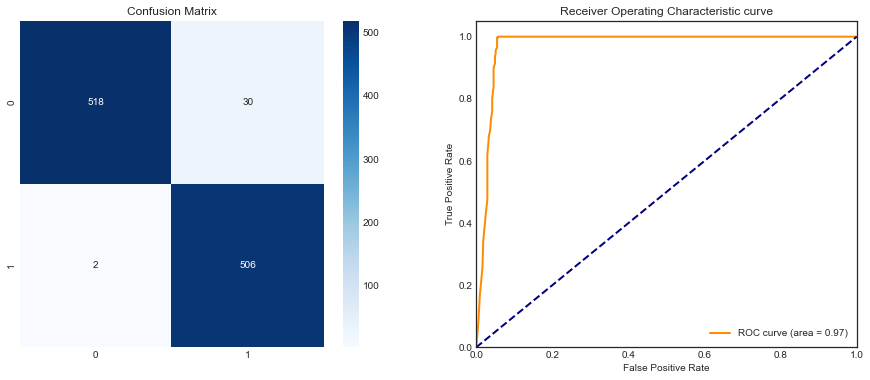

In [ ]:
plot_model_performance(rf_aif, aif_data_test.features, y_test)

In [ ]:
np.random.seed(20211208)

aif_data_tr, aif_data_te = aif_data.split([0.8], shuffle=True)

aif_tr = aif_data_tr.convert_to_dataframe()[0]
aif_te = aif_data_te.convert_to_dataframe()[0]

rf_aift = RandomForestClassifier().fit(aif_tr[['age', 'c_charge_degree', 'race', 'age_cat', 'score_text', 'sex', 
                                               'priors_count', 'days_b_screening_arrest', 'decile_score', 'is_recid', 
                                               'length_of_stay']],
                                       aif_tr['two_year_recid'],
                                       sample_weight=aif_data_train.instance_weights)

X_test = aif_te[['age', 'c_charge_degree', 'race', 'age_cat', 'score_text', 'sex', 'priors_count', 'days_b_screening_arrest',
                 'decile_score', 'is_recid', 'length_of_stay']]
y_test = aif_te['two_year_recid']

In [ ]:
y_pred_AA = rf_aift.predict(X_test[X_test['race']==0])
y_pred_Ca = rf_aift.predict(X_test[X_test['race']==1])
y_test_AA = aif_te[aif_te['race']==0]['two_year_recid']
y_test_Ca = aif_te[aif_te['race']==1]['two_year_recid']

display(Markdown('#### Calibration of the model :'))
print(metrics.accuracy_score(y_test_AA, y_pred_AA)-metrics.accuracy_score(y_test_Ca, y_pred_Ca))

#### Calibration of the model :

-0.0251237412527735


The baseline model has some really good metrics.
# 4. Bias and fairness
## 4.1 Metrics
AIF360 provides some metrics for us to check model fairness. I will use 5 metrics:
* Statistical Parity Difference
* Equal Opportunity Difference
* Average Absolute Odds Difference
* Disparate Impact
* Theil Index

In [ ]:
# This DataFrame is created to stock differents models and fair metrics that we produce in this notebook
algo_metrics = pd.DataFrame(columns=['model', 'fair_metrics', 'prediction', 'probs'])

def add_to_df_algo_metrics(algo_metrics, model, fair_metrics, preds, probs, name):
    return algo_metrics.append(pd.DataFrame(data=[[model, fair_metrics, preds, probs]], columns=['model', 'fair_metrics', 'prediction', 'probs'], index=[name]))

In [ ]:
# This code is based on https://www.kaggle.com/nathanlauga/ethics-and-ai-how-to-prevent-bias-on-ml?scriptVersionId=20652099&cellId=87
def fair_metrics(dataset, pred, pred_is_dataset=False):
    if pred_is_dataset:
        dataset_pred = pred
    else:
        dataset_pred = dataset.copy()
        dataset_pred.labels = pred
    
    cols = ['statistical_parity_difference', 'equal_opportunity_difference', 'average_abs_odds_difference',  'disparate_impact', 'theil_index']
    obj_fairness = [[0,0,0,1,0]]
    
    fair_metrics = pd.DataFrame(data=obj_fairness, index=['objective'], columns=cols)
    
    for attr in dataset_pred.protected_attribute_names:
        idx = dataset_pred.protected_attribute_names.index(attr)
        privileged_groups =  [{attr:dataset_pred.privileged_protected_attributes[idx][0]}] 
        unprivileged_groups = [{attr:dataset_pred.unprivileged_protected_attributes[idx][0]}] 
        
        classified_metric = ClassificationMetric(dataset, 
                                                     dataset_pred,
                                                     unprivileged_groups=unprivileged_groups,
                                                     privileged_groups=privileged_groups)
        
        metric_pred = BinaryLabelDatasetMetric(dataset_pred,
                                                     unprivileged_groups=unprivileged_groups,
                                                     privileged_groups=privileged_groups)

        acc = classified_metric.accuracy()
        
        row = pd.DataFrame([[metric_pred.mean_difference(),
                                classified_metric.equal_opportunity_difference(),
                                classified_metric.average_abs_odds_difference(),
                                metric_pred.disparate_impact(),
                                classified_metric.theil_index()]],
                           columns  = cols,
                           index = [attr]
                          )
        fair_metrics = fair_metrics.append(row)    
    
    fair_metrics = fair_metrics.replace([-np.inf, np.inf], 2)
        
    return fair_metrics

def plot_fair_metrics(fair_metrics):
    fig, ax = plt.subplots(figsize=(20,4), ncols=5, nrows=1)

    plt.subplots_adjust(
        left    =  0.125, 
        bottom  =  0.1, 
        right   =  0.9, 
        top     =  0.9, 
        wspace  =  .5, 
        hspace  =  1.1
    )

    y_title_margin = 1.2

    plt.suptitle("Fairness metrics", y = 1.09, fontsize=20)
    sns.set(style="dark")

    cols = fair_metrics.columns.values
    obj = fair_metrics.loc['objective']
    size_rect = [0.2,0.2,0.2,0.4,0.25]
    rect = [-0.1,-0.1,-0.1,0.8,0]
    bottom = [-1,-1,-1,0,0]
    top = [1,1,1,2,1]
    bound = [[-0.1,0.1],[-0.1,0.1],[-0.1,0.1],[0.8,1.2],[0,0.25]]

    display(Markdown("### Check bias metrics :"))
    display(Markdown("A model can be considered bias if just one of these five metrics show that this model is biased."))
    for attr in fair_metrics.index[1:len(fair_metrics)].values:
        display(Markdown("#### For the %s attribute :"%attr))
        check = [bound[i][0] < fair_metrics.loc[attr][i] < bound[i][1] for i in range(0,5)]
        display(Markdown("With default thresholds, bias against unprivileged group detected in **%d** out of 5 metrics"%(5 - sum(check))))

    for i in range(0,5):
        plt.subplot(1, 5, i+1)
        ax = sns.barplot(x=fair_metrics.index[1:len(fair_metrics)], y=fair_metrics.iloc[1:len(fair_metrics)][cols[i]])
        
        for j in range(0,len(fair_metrics)-1):
            a, val = ax.patches[j], fair_metrics.iloc[j+1][cols[i]]
            marg = -0.2 if val < 0 else 0.1
            ax.text(a.get_x()+a.get_width()/5, a.get_y()+a.get_height()+marg, round(val, 3), fontsize=15,color='black')

        plt.ylim(bottom[i], top[i])
        plt.setp(ax.patches, linewidth=0)
        ax.add_patch(patches.Rectangle((-5,rect[i]), 10, size_rect[i], alpha=0.3, facecolor="green", linewidth=1, linestyle='solid'))
        plt.axhline(obj[i], color='black', alpha=0.3)
        plt.title(cols[i])
        ax.set_ylabel('')    
        ax.set_xlabel('')

In [ ]:
# This code is based on https://www.kaggle.com/nathanlauga/ethics-and-ai-how-to-prevent-bias-on-ml?scriptVersionId=20652099&cellId=88
def get_fair_metrics_and_plot(data, model, plot=True, model_aif=False):
    pred = model.predict(data).labels if model_aif else model.predict(data.features)
    # fair_metrics function available in the metrics.py file
    fair = fair_metrics(data, pred)
    
    if plot:
        # plot_fair_metrics function available in the visualisations.py file
        # The visualisation of this function is inspired by the dashboard on the demo of IBM aif360 
        plot_fair_metrics(fair)
        display(fair)
    
    return fair

### Bias metrics for the Race model

### Check bias metrics :

A model can be considered bias if just one of these five metrics show that this model is biased.

#### For the race attribute :

With default thresholds, bias against unprivileged group detected in **2** out of 5 metrics

,statistical_parity_difference,equal_opportunity_difference,average_abs_odds_difference,disparate_impact,theil_index
objective,0.000000,0.0000,0.0000,1.000000,0.000000
race,0.122433,-0.0059,0.0287,1.283344,0.012196


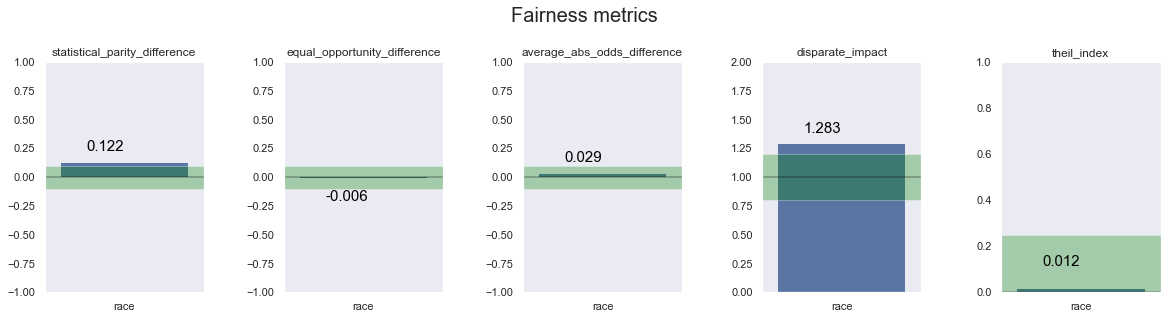

In [ ]:
display(Markdown('### Bias metrics for the Race model'))
fair = get_fair_metrics_and_plot(aif_data_test, rf_aif)

As we can see this model is not really biased, but it can be better and for this example we will look how to mitigate those bias.

In [ ]:
data_test = aif_data_test
data_train = aif_data_train
rf = rf_aif

probs = rf.predict_proba(data_test.features)
preds = rf.predict(data_test.features)
algo_metrics = add_to_df_algo_metrics(algo_metrics, rf, fair, preds, probs, 'Origin')

In [ ]:
algo_metrics

,model,fair_metrics,prediction,probs
Origin,"(DecisionTreeClassifier(max_features='auto', r...",statistical_parity_difference equa...,"[1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","[[0.16, 0.84], [0.19, 0.81], [0.11, 0.89], [0...."


## 4.2. Other algorithms

### 4.2.2. Fairness-aware Classifier with Prejudice Remover Regularizer

In [ ]:
%run A5.py

<Figure size 432x288 with 0 Axes>

### Check bias metrics :

A model can be considered bias if just one of these five metrics show that this model is biased.

#### For the race attribute :

With default thresholds, bias against unprivileged group detected in **2** out of 5 metrics

,statistical_parity_difference,equal_opportunity_difference,average_abs_odds_difference,disparate_impact,theil_index
objective,0.000000,0.0,0.000000,1.000000,0.000000
race,0.127041,0.0,0.027352,1.294009,0.010602


time elapsed : 14.39s


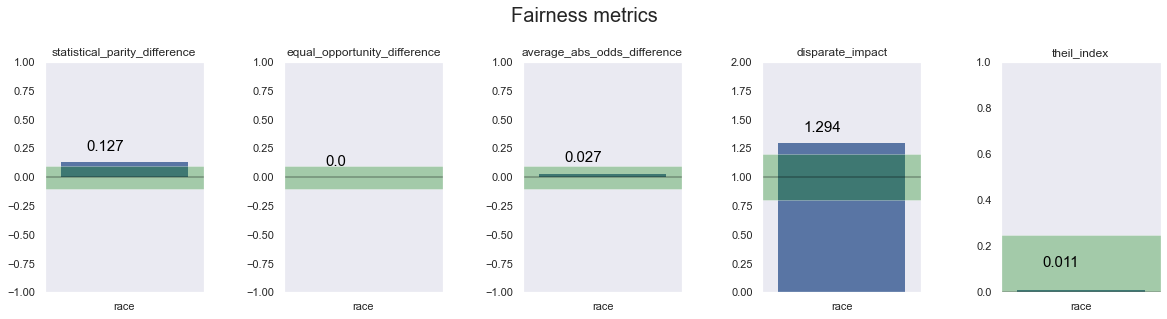

In [ ]:
t0 = time()
debiased_model = PrejudiceRemover(sensitive_attr="race", eta = 25.0)
debiased_model.fit(data_train)

fair = get_fair_metrics_and_plot(data_test, debiased_model, plot=True, model_aif=True)
data_pred = debiased_model.predict(data_test)

algo_metrics = add_to_df_algo_metrics(algo_metrics, debiased_model, fair, data_pred.labels, data_pred.scores, 'PrejudiceRemover')
print('time elapsed : %.2fs'%(time()-t0))

In [ ]:
display(Markdown('#### Accuracy of the model :'))
print(metrics.accuracy_score(data_test.labels, data_pred.labels))

#### Accuracy of the model :

0.9706439393939394


In [ ]:
df_p = data_pred.convert_to_dataframe()[0]
df_p_AA = df_p[df_p['race']==0]
df_p_Ca = df_p[df_p['race']==1]
df_t = data_test.convert_to_dataframe()[0]
df_t_AA = df_t[df_t['race']==0]
df_t_Ca = df_t[df_t['race']==1]

display(Markdown('#### Calibration of the model :'))
print(metrics.accuracy_score(df_t_AA['two_year_recid'], df_p_AA['two_year_recid'])-
      metrics.accuracy_score(df_t_Ca['two_year_recid'], df_p_Ca['two_year_recid']))

#### Calibration of the model :

-0.023587642942481613


In [ ]:
def compare_fair_metrics(algo_metrics, attr='race'):
    
    df_metrics = pd.DataFrame(columns=algo_metrics.loc['Origin','fair_metrics'].columns.values)
    for fair in algo_metrics.loc[:,'fair_metrics']:
        df_metrics = df_metrics.append(fair.loc[attr], ignore_index=True)

    df_metrics.index = algo_metrics.index.values
    df_metrics = df_metrics.replace([np.inf, -np.inf], np.NaN)
    
    display(df_metrics)

In [ ]:
compare_fair_metrics(algo_metrics)

,statistical_parity_difference,equal_opportunity_difference,average_abs_odds_difference,disparate_impact,theil_index
Origin,0.122433,-0.0059,0.028700,1.283344,0.012196
PrejudiceRemover,0.127041,0.0000,0.027352,1.294009,0.010602
